# Lag-Llama Time Series Forecasting

In [1]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

fatal: destination path 'lag-llama' already exists and is not an empty directory.


In [2]:
%cd lag-llama

/storage/BerlinWeatherTimeSeriesAnalysis/lag-llama


In [3]:
%pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /storage/BerlinWeatherTimeSeriesAnalysis/lag-llama

/storage/BerlinWeatherTimeSeriesAnalysis/lag-llama/lag-llama.ckpt


In [5]:
from itertools import islice

import pandas as pd
import numpy as np
import matplotlib.dates as mdates
from matplotlib import pyplot as plt
from tqdm.autonotebook import tqdm

import torch

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.common import ListDataset

from lag_llama.gluon.estimator import LagLlamaEstimator
from torch.serialization import add_safe_globals
from gluonts.torch.modules.loss import NegativeLogLikelihood
from gluonts.torch.distributions.studentT import StudentTOutput
add_safe_globals([NegativeLogLikelihood, StudentTOutput])

/tmp/ipykernel_625/1310194502.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Read in Data

In [6]:
# Read in data
years = ["2020", "2021", "2022", "2023", "2024"]
columns = ["ISO Time", "Temperature (C)", "Humidity (%)", "Pressure (kPa)", "Air Quality (Ohms)"]
all_data = pd.read_csv("/storage/BerlinWeatherTimeSeriesAnalysis/data/2019_BME680SensorData.csv", usecols=columns)

for year in years:
    data_filename = f"/storage/BerlinWeatherTimeSeriesAnalysis/data/{year}_BME680SensorData.csv"
    read_in_data = pd.read_csv(data_filename, usecols=columns)
    all_data = pd.concat([all_data, read_in_data], ignore_index=True)

print("Data Collected")
all_data.head()


all_data["ISO Time"] = pd.to_datetime(all_data["ISO Time"])
all_data["Date"] = all_data["ISO Time"].dt.date
all_data["Hour"] = all_data["ISO Time"].dt.hour
hourly_avg = all_data.groupby(["Date", "Hour"]).mean()
hourly_avg

Data Collected


ISO Time  Temperature (C)  Humidity (%)  \
Date       Hour                                                                
2019-01-01 0    2019-01-01 00:29:31.316666624         4.293500    100.000000   
           1    2019-01-01 01:29:31.300000000         4.125000    100.000000   
           2    2019-01-01 02:29:31.300000000         4.056333    100.000000   
           3    2019-01-01 03:29:31.333333248         3.946500    100.000000   
           4    2019-01-01 04:29:31.349999872         3.739667    100.000000   
...                                       ...              ...           ...   
2024-12-31 19   2024-12-31 19:29:31.783333120         3.260667     87.923000   
           20   2024-12-31 20:27:45.234042624         3.269362     86.244255   
           21   2024-12-31 21:30:40.961538560         3.188462     86.157500   
           22   2024-12-31 22:30:33.415094272         3.008491     85.458868   
           23   2024-12-31 23:29:45.310344704         2.883103     85.040517   

                 Pressure (kPa)  Air Quality (Ohms)  
Date       Hour                                      
2019-01-01 0          97.444250        3.253975e+04  
           1          97.446067        3.273012e+04  
           2          97.384150        3.299228e+04  
           3          97.308767        3.124677e+04  
           4          97.258917        3.359688e+04  
...                         ...                 ...  
2024-12-31 19        101.286583        1.069465e+06  
           20        101.242021        1.062867e+06  
           21        101.193154        1.044766e+06  
           22        101.163792        1.117850e+06  
           23        101.073000        1.031384e+06  

[51931 rows x 5 columns]

In [7]:
data = hourly_avg["Temperature (C)"]

# Reset the index so you can combine Date and Hour into a single datetime column
data = data.reset_index()
data['datetime'] = pd.to_datetime(data['Date']) + pd.to_timedelta(data['Hour'], unit='h')
data = data.set_index('datetime')
data.drop(columns=["Date", "Hour"], inplace=True)
data

,Temperature (C)
datetime,
2019-01-01 00:00:00,4.293500
2019-01-01 01:00:00,4.125000
2019-01-01 02:00:00,4.056333
2019-01-01 03:00:00,3.946500
2019-01-01 04:00:00,3.739667
...,...
2024-12-31 19:00:00,3.260667
2024-12-31 20:00:00,3.269362
2024-12-31 21:00:00,3.188462


<Figure size 1400x500 with 0 Axes>

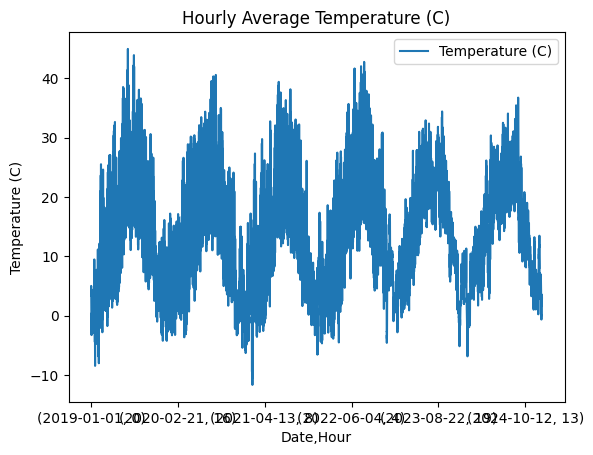

In [8]:
plt.figure(figsize=(14, 5))
hourly_avg.plot(y="Temperature (C)")
plt.title(f"Hourly Average Temperature (C)")
plt.ylabel("Temperature (C)")
plt.show()

## Model Setup

In [9]:
prediction_length = 24  # Predict one day ahead
context_length = prediction_length * 7 # One week context 
num_samples = 20
device = "cuda"
batch_size = 64

In [10]:
ckpt_path = "/storage/BerlinWeatherTimeSeriesAnalysis/lag-llama/lag-llama.ckpt"
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

zs_estimator = LagLlamaEstimator(
    ckpt_path=ckpt_path,
    prediction_length=prediction_length,
    context_length=context_length,
    device=torch.device(device),

    # estimator args
    input_size=estimator_args['input_size'],
    n_layer=estimator_args['n_layer'],
    n_embd_per_head=estimator_args['n_embd_per_head'],
    n_head=estimator_args['n_head'],
    scaling=estimator_args['scaling'],
    time_feat=estimator_args['time_feat'],
    
    nonnegative_pred_samples=True,

    # Linear Positional Encoding Scaling
    rope_scaling={
        "type":"linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    },

    batch_size=batch_size,
    num_parallel_samples=num_samples
)


zs_predictor = zs_estimator.create_predictor(zs_estimator.create_transformation(), zs_estimator.create_lightning_module())

Zero-Shot Prediction

In [11]:
test_data = pd.read_csv("/storage/BerlinWeatherTimeSeriesAnalysis/data/2025_BME680SensorData.csv", usecols=columns)
test_data["ISO Time"] = pd.to_datetime(test_data["ISO Time"])
test_data["Date"] = test_data["ISO Time"].dt.date
test_data["Hour"] = test_data["ISO Time"].dt.hour
hourly_avg_test = test_data.groupby(["Date", "Hour"]).mean()
hourly_avg_test

test_data = hourly_avg_test["Temperature (C)"]

# Reset the index so you can combine Date and Hour into a single datetime column
test_data = test_data.reset_index()
test_data['datetime'] = pd.to_datetime(test_data['Date']) + pd.to_timedelta(test_data['Hour'], unit='h')
test_data = test_data.set_index('datetime')
test_data.drop(columns=["Date", "Hour"], inplace=True)
test_data["Temperature (C)"] = test_data["Temperature (C)"].astype(np.float32)

In [12]:
#valid_end = round(len(test_data) * 0.9)
n_days_to_predict = 160
date_list = pd.date_range(test_data.index[2] + pd.Timedelta(hours=24), periods=n_days_to_predict, freq="1d").tolist()

zs_forecasts = []
zs_tss = []

for d in date_list:
  print(d)
  forecast_it, ts_it = make_evaluation_predictions(
          dataset=PandasDataset(test_data[:d], freq="1h", target="Temperature (C)"),
          predictor=zs_predictor,
          num_samples=num_samples
  )
  zs_forecasts.append(list(forecast_it))
  zs_tss.append(list(ts_it))


2025-01-02 02:00:00
2025-01-03 02:00:00
2025-01-04 02:00:00
2025-01-05 02:00:00
2025-01-06 02:00:00
2025-01-07 02:00:00
2025-01-08 02:00:00
2025-01-09 02:00:00
2025-01-10 02:00:00
2025-01-11 02:00:00
2025-01-12 02:00:00
2025-01-13 02:00:00
2025-01-14 02:00:00
2025-01-15 02:00:00
2025-01-16 02:00:00
2025-01-17 02:00:00
2025-01-18 02:00:00
2025-01-19 02:00:00
2025-01-20 02:00:00
2025-01-21 02:00:00
2025-01-22 02:00:00
2025-01-23 02:00:00
2025-01-24 02:00:00
2025-01-25 02:00:00
2025-01-26 02:00:00
2025-01-27 02:00:00
2025-01-28 02:00:00
2025-01-29 02:00:00
2025-01-30 02:00:00
2025-01-31 02:00:00
2025-02-01 02:00:00
2025-02-02 02:00:00
2025-02-03 02:00:00
2025-02-04 02:00:00
2025-02-05 02:00:00
2025-02-06 02:00:00
2025-02-07 02:00:00
2025-02-08 02:00:00
2025-02-09 02:00:00
2025-02-10 02:00:00
2025-02-11 02:00:00
2025-02-12 02:00:00
2025-02-13 02:00:00
2025-02-14 02:00:00
2025-02-15 02:00:00
2025-02-16 02:00:00
2025-02-17 02:00:00
2025-02-18 02:00:00
2025-02-19 02:00:00
2025-02-20 02:00:00


Evaluation

In [13]:
evaluator = Evaluator()
zs_a_metrics = [] # aggregated forecast metrics, we'll use the MAPE metric to evaluate
zs_t_metrics = [] # information about each time series, we'll use this to graph


mape_list = []
mase_list = []
mse_list = []
rmse_list = []

for (t, s) in tqdm(zip(zs_tss, zs_forecasts), total=len(zs_forecasts)):
    agg_metrics, ts_metrics = evaluator(t, s)
    zs_a_metrics.append(agg_metrics)
    zs_t_metrics.append(ts_metrics)
    
    # Extract the metrics
    mape = agg_metrics.get('MAPE')
    mase = agg_metrics.get('MASE')
    mse = agg_metrics.get('MSE')
    
    # Calculate RMSE from MSE
    rmse = np.sqrt(mse) if mse is not None else None
    
    # Append to lists
    mape_list.append(mape)
    mase_list.append(mase)
    mse_list.append(mse)
    rmse_list.append(rmse)

  0%|          | 0/160 [00:00<?, ?it/s]

Running evaluation: 1it [00:02,  2.90s/it]
Running evaluation: 1it [00:01,  1.83s/it]s/it]
Running evaluation: 1it [00:01,  1.89s/it]s/it]
Running evaluation: 1it [00:01,  1.90s/it]s/it]
Running evaluation: 1it [00:01,  1.96s/it]s/it]
Running evaluation: 1it [00:01,  1.84s/it]s/it]
Running evaluation: 1it [00:01,  1.88s/it]s/it]
Running evaluation: 1it [00:01,  1.84s/it]s/it]
Running evaluation: 1it [00:01,  1.93s/it]s/it]
Running evaluation: 1it [00:01,  1.82s/it]s/it]
Running evaluation: 1it [00:01,  1.86s/it]9s/it]
Running evaluation: 1it [00:01,  1.90s/it]5s/it]
Running evaluation: 1it [00:01,  1.81s/it]6s/it]
Running evaluation: 1it [00:01,  1.96s/it]3s/it]
Running evaluation: 1it [00:01,  1.85s/it]2s/it]
Running evaluation: 1it [00:01,  1.84s/it]2s/it]
Running evaluation: 1it [00:01,  1.83s/it]2s/it]
Running evaluation: 1it [00:01,  1.76s/it]3s/it]
Running evaluation: 1it [00:01,  1.88s/it]5s/it]
Running evaluation: 1it [00:01,  1.98s/it]3s/it]
Running evaluation: 1it [00:01,  1.

In [14]:
print("Average Metrics (Over all predicted sequences)\n\n")
print(f"Average RMSE: {np.mean(rmse_list)}")
print(f"Average MAPE: {np.mean(mape_list)}")
print(f"Average MASE: {np.mean(mase_list)}")

Average Metrics (Over all predicted sequences)


Average RMSE: 2.4093623640624786
Average MAPE: 0.7886649260452637
Average MASE: 1.3663536054689158


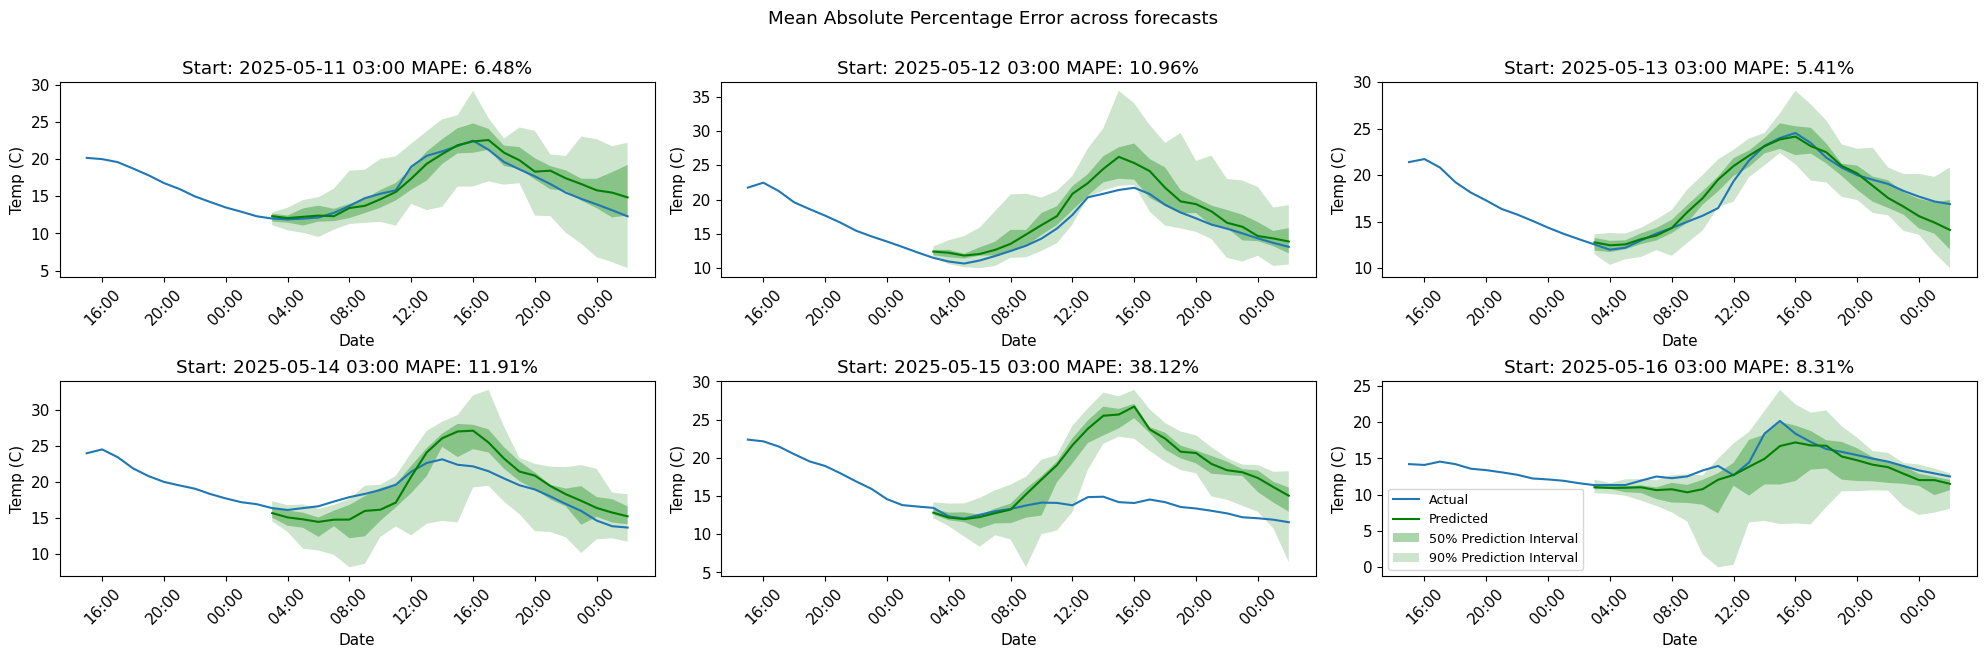

In [15]:
plt.figure(figsize=(20, 9))
plt.rcParams.update({'font.size': 11})
date_formater = mdates.DateFormatter('%H:%M') #%b %d \'%y %H')

offset = 130
numplots = 6
for idx in range(len(zs_forecasts[offset:(offset+numplots)])):
  t_idx = idx + offset
  ax = plt.subplot(3, 3, idx+1)
  t = zs_tss[t_idx][0][zs_forecasts[t_idx][0].start_date.to_timestamp() - pd.Timedelta(hours=12):]
  
  smape = float(f'{zs_t_metrics[t_idx]["MAPE"][0]:.4f}') * 100.0
  smape = float(f'{smape:.2f}')
  ax.set_title("Start: " + str(zs_t_metrics[t_idx]["forecast_start"][0]) + " MAPE: " + str(smape) + "%")
  plt.plot(t.index.to_timestamp(), t[0])
  ax.xaxis.set_major_formatter(date_formater)
  #ax.set_ticks()
  #ax.set_xticklabels(fontsize="small") #["Day " + str(i + 1) for i in range(7)], fontsize="small")
  ax.set_xlabel('Date')
  ax.set_ylabel('Temp (C)')
  zs_forecasts[t_idx][0].plot(color='g')
  plt.xticks(rotation=45)

plt.gcf().tight_layout()
plt.subplots_adjust(top=0.9)
plt.suptitle("Mean Absolute Percentage Error across forecasts")
plt.legend(["Actual", "Predicted",'50% Prediction Interval', '90% Prediction Interval'], fontsize="small")
plt.show()